In [1]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
%load_ext tensorboard
print(tf.__version__)

2.1.0


In [2]:
dataset = h5py.File('simu_HDF_new.h5', 'r')
num_diodes = dataset['Num_diodes'][...]
x_pos = (dataset['Xpos'][...])/100
y_pos = dataset['Ypos'][...]
histgrid = dataset['histgrid'][...]
dataset.close()

In [3]:
histgrid.shape

(9, 132, 1011)

In [4]:
histgrid[0,0:132,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
#Testing lists vs arrays
all_data = []
all_labels = []
for i in range(10):
    all_data.append(i)
    all_labels.append(i)
print(all_data,all_labels)
np.array(all_data)
np.array(all_labels)
print(all_data,all_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
x_pos

array([-16., -24., -32.,  -8.,   0.,  16.,  24.,  32.,   8.])

In [7]:

def data_compile(histdata):
    data = []
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j])
            labels.append(x_pos[i])
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)
all_data.reshape(-1,1)
all_data = normalize(all_data,axis = 1)
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)

In [8]:
train_data.ndim

2

In [9]:
train_data.shape

(7272, 132)

In [10]:
train_data[0]

array([0.        , 0.        , 0.        , 0.0035652 , 0.        ,
       0.01069561, 0.0035652 , 0.00713041, 0.0035652 , 0.15330377,
       0.27808591, 0.3565204 , 0.18895581, 0.04278245, 0.0035652 ,
       0.0035652 , 0.        , 0.0035652 , 0.        , 0.        ,
       0.        , 0.00713041, 0.0035652 , 0.        , 0.        ,
       0.        , 0.        , 0.0035652 , 0.        , 0.0035652 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0035652 , 0.        , 0.        , 0.        ,
       0.        , 0.01426082, 0.12834734, 0.22460785, 0.32086836,
       0.22460785, 0.05704326, 0.00713041, 0.0035652 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0035652 ,
       0.        , 0.        , 0.        , 0.0035652 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00713041, 0.        , 0.0035652 , 0.     

In [ ]:
#Clear previous runs
!rm -rf ./logs/ 

In [11]:
log_dir = "logs/fit/" + "O-PPAC_FCNN" + "RMSprop0.001,mse,no_dropout,1dense128,relu"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(layers.Dense(1, activation = 'linear'))

In [14]:
FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [15]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Train on 5090 samples, validate on 2182 samples
Epoch 1/100
5090/5090 [==============================] - 1s 249us/sample - loss: 62.5742 - mae: 4.5557 - mse: 62.5742 - val_loss: 1.7156 - val_mae: 1.1268 - val_mse: 1.7156
Epoch 2/100
5090/5090 [==============================] - 1s 131us/sample - loss: 5.1900 - mae: 1.7173 - mse: 5.1900 - val_loss: 1.6113 - val_mae: 1.0402 - val_mse: 1.6113
Epoch 3/100
5090/5090 [==============================] - 1s 123us/sample - loss: 5.0064 - mae: 1.6344 - mse: 5.0064 - val_loss: 3.7780 - val_mae: 1.5612 - val_mse: 3.7780
Epoch 4/100
5090/5090 [==============================] - 1s 115us/sample - loss: 4.7733 - mae: 1.5916 - mse: 4.7733 - val_loss: 1.4804 - val_mae: 1.0159 - val_mse: 1.4804
Epoch 5/100
5090/5090 [==============================] - 1s 115us/sample - loss: 4.7334 - mae: 1.5670 - mse: 4.7334 - val_loss: 1.2254 - val_mae: 0.8612 - val_mse: 1.2254
Epoch 6/100
5090/5090 [==============================] - 1s 118us/sample - loss: 4.8009 - mae: 

In [ ]:
%tensorboard --logdir logs/fit

Text(0.5, 1.0, 'FCNN O-PPAC Loss Curve, Dropout 0.5, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation')

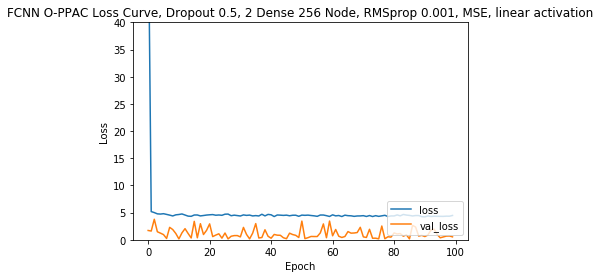

In [16]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 40])
plt.legend(loc='lower right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0.5, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

In [18]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

1818/1818 - 0s - loss: 0.5412 - mae: 0.6077 - mse: 0.5412


In [19]:
predictions = FCNN_model.predict(test_data)

In [31]:
predictions[0]

array([0.01109481], dtype=float32)

In [32]:
test_labels.shape[0]

1818

In [33]:
test_labels[:]

array([  0.,   8., -16., ...,  32.,  -8., -24.])

In [34]:
new_labels = []
for i in range(test_labels.shape[0]):
    new_labels.append([test_labels[i]])
np.array(new_labels)
new_labels[2]

[-16.0]

Text(0.5, 1.0, 'FCNN O-PPAC Predictions vs True Values')

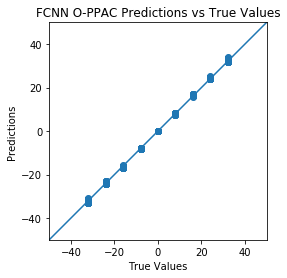

In [35]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC Predictions vs True Values")